In [414]:
# basics
import pandas as pd
import numpy as np

# maps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# prep
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# feature engineering
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# modelling
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

# evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

forest = '#284e13ff'

# xgb_cv_r2 = {x: np.nan for x in list(range(5))}
# xgb_cv_mape = {x: np.nan for x in list(range(5))}
# xgb_cv_mse = {x: np.nan for x in list(range(5))}
# sample_size = {x: np.nan for x in list(range(5))}
# baseline_r2 = {x: np.nan for x in list(range(5))}
# baseline_mape = {x: np.nan for x in list(range(5))}
# baseline_mse = {x: np.nan for x in list(range(5))}


In [415]:
areas_list = ['', '_1950', '_2910', '_4830', '_7710']

############ PICK AREA SIZE HERE ##############
area = areas_list[0]
###############################################

file_to_load = 'data/regression_sample' + area + '.csv'
index = areas_list.index(area)



In [416]:
df = pd.read_csv(file_to_load, sep = "\t")

# Define a dictionary with the features to convert to 'category'
to_category = {'sector_main': 'category', 'country': 'category', 'start_year_first': 'category'}

# Convert the features to 'category' dtype
df = df.astype(to_category)

In [417]:
sector_means = df[df.defo_total > 0].groupby('sector_main').around_3.describe().reset_index()[['sector_main', 'mean', 'count']]

row_total = {'sector_main': 'total', 'mean':df[df.defo_total > 0].around_3.mean(), 'count': df[df.defo_total > 0].around_3.count()}
row_total_df = pd.DataFrame([row_total])

sector_means = pd.concat([sector_means, row_total_df], ignore_index=True).sort_values('mean')

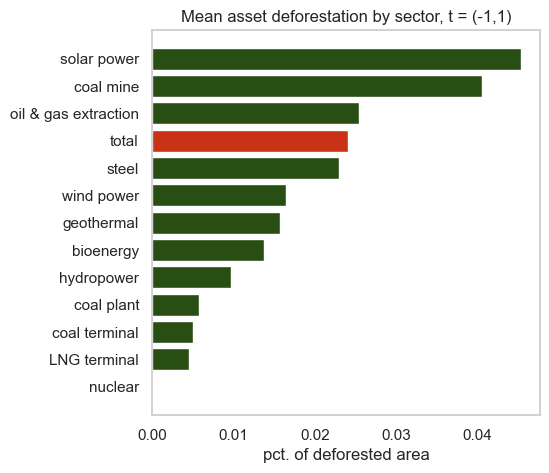

In [419]:
fig = plt.figure(figsize=(5, 5))

colors = [forest] * len(sector_means)
colors[9] = '#c83215'

plt.barh(sector_means.sector_main, sector_means['mean'], color = colors)
plt.title('Mean asset deforestation by sector, t = (-1,1)')
plt.xlabel("pct. of deforested area")
plt.grid()
plt.show()

fig.savefig('graphs/hbar_means_by_sector.png', bbox_inches='tight')

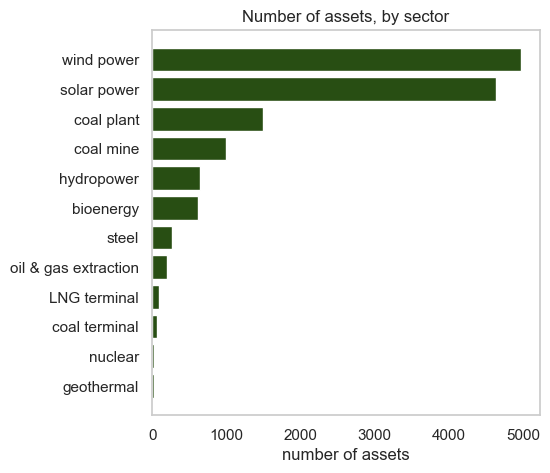

12

In [420]:
sector_counts = df.groupby('sector_main').around_3.describe().reset_index()[['sector_main', 'mean', 'count']].sort_values('count')

fig = plt.figure(figsize=(5, 5))


plt.barh(sector_counts.sector_main, sector_counts['count'], color = forest)
plt.title('Number of assets, by sector')
plt.xlabel('number of assets')
plt.grid()
plt.show()

fig.savefig('graphs/hbar_sectors.png', bbox_inches='tight')
df[(df.treecover2000 > 0) & (df.defo_total > 0)].sector_main.nunique()

# Simple modelling

In [316]:
df.columns

Index(['uid_gem', 'latitude', 'longitude', 'sector_main', 'sector_main_num',
       'capacity_unit', 'country', 'asset_name', 'owner_name', 'index',
       'capacity_first', 'start_year_first', 'sector_sub_first', 'capacity',
       'start_year', 'sector_sub', 'number_units', 'row', 'col',
       'treecover2000', 'defo_total', 't_m3', 't_m2', 't_m1', 't_0', 't_1',
       't_2', 't_3', 'around_3', 'around_5', 'forward_3', 'past_3'],
      dtype='object')

,latitude,longitude,sector_main_num,index,capacity_first,number_units,row,col,treecover2000,defo_total,...,t_m1,t_0,t_1,t_2,t_3,around_3,around_5,forward_3,past_3,country_count
count,4920.000000,4920.000000,4920.000000,4920.000000,4878.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,...,4920.000000,4920.000000,4920.000000,4480.000000,3944.000000,4920.000000,4419.000000,4480.000000,4859.000000,4920.000000
mean,24.534344,73.425315,7.293089,20789.511382,251.643566,1.318699,-58137.796341,573700.870732,20.949593,0.101736,...,0.012252,0.008158,0.003722,0.003275,0.002857,0.024132,0.036763,0.014841,0.030514,1674.718699
std,17.989316,78.585140,3.712349,10603.558761,1274.958231,1.046808,71957.272297,314340.535653,34.580786,0.186257,...,0.055423,0.035568,0.019938,0.020211,0.018480,0.075961,0.095957,0.050844,0.087771,1277.962041
min,-42.161400,-159.492000,0.000000,93.000000,0.000000,1.000000,-215418.000000,-357968.000000,0.000000,0.000918,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,21.683204,99.402100,3.000000,12357.750000,30.000000,1.000000,-103854.750000,677608.000000,0.000000,0.004362,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217.000000
50%,28.891963,110.679535,9.000000,19676.500000,50.000000,1.000000,-75568.500000,722717.500000,0.000000,0.019284,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002755,0.000000,0.000918,2788.000000
75%,35.963641,116.556700,11.000000,29911.500000,100.000000,1.000000,-46733.000000,746226.500000,41.250000,0.093664,...,0.001837,0.000918,0.000000,0.000000,0.000000,0.013774,0.024793,0.006428,0.016529,2788.000000
max,63.854431,149.885000,11.000000,37870.000000,29510.000000,21.000000,208645.000000,879540.000000,100.000000,0.998163,...,0.986226,0.645546,0.482094,0.439853,0.576676,0.986226,0.986226,0.862259,0.986226,2788.000000


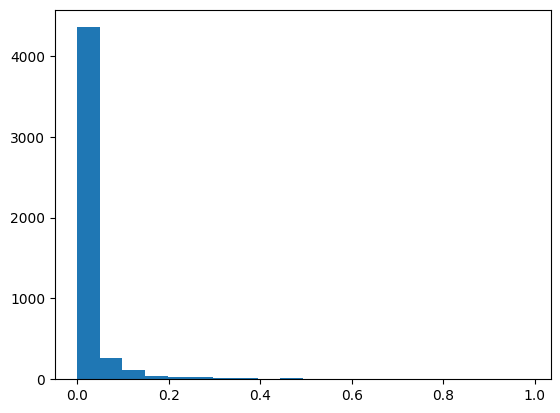

In [317]:
y_var = 'around_3'

df_pred = df[df[y_var].notnull()]
# df_pred = df_pred[df_pred.treecover2000 > 0]
# df_pred = df_pred[df_pred.start_year_first < 2013]
df_pred = df_pred[df_pred.defo_total > 0]

aux_country = df_pred.groupby('country').uid_gem.count().reset_index().sort_values('uid_gem').rename(columns = {'uid_gem': 'country_count'})
df_pred = pd.merge(df_pred, aux_country, how = 'inner', on = 'country')

df_pred = df_pred[df_pred.country_count > 1]

plt.hist(df_pred.around_3, bins = 20)
df_pred.describe()

# df.groupby('quintile_capacity').count()

In [318]:
X_cols = ['sector_main', 'country', 'number_units', 'start_year_first'] #, 'defo_total']
X = df_pred[X_cols]
X_strat = df_pred[['country']]
y = df_pred[y_var].apply(lambda x: np.log(x + 1))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = X_strat)
X_train.dtypes

sector_main         category
country             category
number_units           int64
start_year_first    category
dtype: object

(array([3141.,  163.,   49.,   34.,   22.,   15.,    4.,    8.,    4.,
           4.]),
 array([0.        , 0.06862363, 0.13724726, 0.20587089, 0.27449452,
        0.34311815, 0.41174178, 0.48036541, 0.54898904, 0.61761267,
        0.6862363 ]),
 <BarContainer object of 10 artists>)

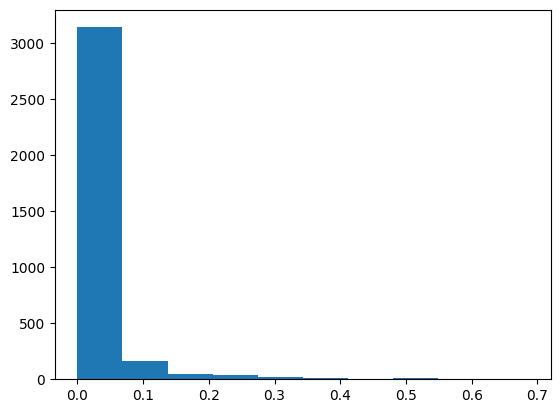

In [319]:
sample_size[index] = len(X_train)
plt.hist(y_train)

# Preprocessing

In [320]:
# Create a ColumnTransformer to handle string data
preprocessor = ColumnTransformer(
    transformers=[
        ('country', OneHotEncoder(), ['country']),
        # ('sector_sub_first', OneHotEncoder(), ['sector_sub_first']),
        ('sector_main', OneHotEncoder(), ['sector_main']),
    ],
    remainder='passthrough'
)


# Baseline model: mean

In [321]:
mean = np.mean(y_train)

y_pred = [mean] * len(y_test)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
baseline_string = f"Baseline output: r2 of {round(r2, 5)}, mape of {round(mape, 6)}"
print(baseline_string)
# y_train.describe()

baseline_r2[index] = round(r2, 5)
baseline_mape[index] = round(mape/10**9, 5) 
baseline_mse[index] = round(mse, 5) 

Baseline output: r2 of -0.00301, mape of 51746708065731.14


# Linear regression

In [322]:
# Create the pipeline
lm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('country', OneHotEncoder(),
                                                  ['country']),
                                                 ('sector_main',
                                                  OneHotEncoder(),
                                                  ['sector_main'])])),
                ('regressor', LinearRegression())])

# KNN regression

In [323]:
# Create the pipeline
knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('country', OneHotEncoder(),
                                                  ['country']),
                                                 ('sector_main',
                                                  OneHotEncoder(),
                                                  ['sector_main'])])),
                ('regressor', KNeighborsRegressor())])

# XGBoost

In [324]:
xgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(enable_categorical = True))
])
xgbm.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('country', OneHotEncoder(),
                                                  ['country']),
                                                 ('sector_main',
                                                  OneHotEncoder(),
                                                  ['sector_main'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [325]:
# The learning rate (Greek letter eta) controls the step size at which the optimizer makes updates to the weights. 
# A smaller eta value results in slower but more accurate updates, while a larger eta value results 
# in faster but less accurate updates.

# The subsample parameter controls the fraction of observations used for each tree. A smaller subsample 
# value results in smaller and less complex models, which can help prevent overfitting.

# For any given problem, a lower log loss value means better predictions.

# You don't need xgboost.cv to find the optimal number of trees. You can also 
# run xgboost.train with "early_stopping_rounds" set. 

X_train_t = preprocessor.fit_transform(X_train, y_train)
X_test_t = preprocessor.fit_transform(X_test, y_test)

#xgb.callback.TrainingCallback()

# res.best_iteration
# is most likely to be the last one but maybe not...

# n_estimators
# num_boosting_rounds

# Tune max_depth and min_child_weight first as they will have the highest impact on the model outcome.

# could provide a DataFrame with all desired combinations...
# then keep track of the results to choose the best...

# def fit(xgbm, **kwargs):

#     data_dmatrix = xgb.DMatrix(data=X_train_t, label=y_train)

#     # other parameters include max_depth, min_child_weight...
#     # defaults are all within a good range

#     # run cv for each model...
#     # GridSearchCV could be useful...

#     params = {'objective':'reg:squarederror',
#               'eval_metric':'rmse',
#               'eta': x[0],
#               'subsample':x[1]}
#     # stratified=True ???
#     # num_boost_round can be set high, 
#     xgb_cv = xgb.cv(dtrain=data_dmatrix, 
#                     params=params, 
#                     nfold=5, 
#                     early_stopping_rounds=50, # over all folds...
#                     metrics = 'rmse', 
#                     seed=42)
#     print(xgb_cv.shape)
#     print(xgb_cv)
#     return xgb_cv[-1:].values[0]

# grid = pd.DataFrame({'eta':[0.01,0.05,0.1]*2, 
#                      'subsample':np.repeat([0.1,0.3],3),
#                      })

# grid[['train-rmse-mean','train-rmse-std',
#     'test-rmse-mean','test-rmse-std']] = grid.apply(fit, axis=1, result_type='expand')

# params = {'objective':'reg:squarederror',
#             'eval_metric':'rmse',
#             'eta': grid.iloc[4].eta,
#             'subsample': grid.iloc[4].subsample}
# regressor = XGBRegressor(**params)

def fit_for_early_stopping(boost, X_train, y_train, cv = 5, early_stopping_rounds = 50):
    params = boost.get_params()
    xgtrain = xgb.DMatrix(X_train, y_train)
    cvresult = xgb.cv(boost.get_xgb_params(), xgtrain, num_boost_round=params['n_estimators'], nfold=cv,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
    boost.set_params(n_estimators = cvresult.shape[0])
    print(cvresult.shape[0])

xgbr = XGBRegressor(
    learning_rate = 0.1, # eta
    n_estimators = 1000,
    max_depth=7,
    #min_child_weight=1,
    gamma = 0,
    #subsample=0.8,
    #colsample_bytree=0.8,
    #objective= 'reg:squarederror',
    seed = 42, 
    enable_categorical = True)

# fit n_estimators on training data for early stopping
fit_for_early_stopping(xgbr, X_train_t, y_train, cv = 5, early_stopping_rounds = 50)

param_grid = {
    'eta': [0.00001, 0.0001, 0.001, 0.01], #0.0001, 0.001,
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5], 
    'min_child_weight': [0.001, 0.01, 0.05, 0.1, 0.5],
    'max_depth': list(range(5, 10, 2)),
    'gamma': [0],
    'alpha': [0, 1, 10, 100],
}

gridsearch = GridSearchCV(xgbr, param_grid, verbose = 0, cv = 5, n_jobs = -1)

gridsearch.fit(X_train_t, y_train)

xgbm2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', gridsearch.best_estimator_)
])
xgbm2.fit(X_train, y_train)

gridsearch.best_params_



20


{'alpha': 0,
 'eta': 1e-05,
 'gamma': 0,
 'max_depth': 7,
 'min_child_weight': 0.001,
 'subsample': 0.5}

# Evaluate 

In [326]:

y_pred = lm.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Linreg output: r2 of {round(r2, 3)}, mse of {round(mse, 6)}")

# # ---------------------------------------------------------
# print("----" * 10)

# y_pred = knn.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print(f"KNN output: r2 of {round(r2, 3)}, mse of {round(mse, 6)}")

# # ---------------------------------------------------------
# print("----" * 10)

print("XGB:")

y_pred = xgbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"XGB output: r2 of {round(r2, 3)}, mse of {round(mse, 6)}")

print("--- on train ---")

y_pred = xgbm.predict(X_train)
mse = mean_squared_error(y_train, y_pred)   
r2 = r2_score(y_train, y_pred)
print(f"r2 of {round(r2, 3)}, mse of {round(mse, 6)}")

print("XGB (cv):")

y_pred = xgbm2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
print(f"XGB (cv) output: r2 of {round(r2, 3)}, mse of {round(mse, 6)}")

xgb_cv_r2[index] = round(r2, 5)
xgb_cv_mse[index] = round(mse, 5) 
xgb_cv_mape[index] = round(mape/10**9, 5)


print("--- on train ---")

y_pred = xgbm2.predict(X_train)
mse = mean_squared_error(y_train, y_pred)   
r2 = r2_score(y_train, y_pred)
print(f"r2 of {round(r2, 3)}, mse of {round(mse, 6)}")

Linreg output: r2 of 0.069, mse of 0.002945
XGB:
XGB output: r2 of -0.099, mse of 0.003477
--- on train ---
r2 of 0.412, mse of 0.002432
XGB (cv):
XGB (cv) output: r2 of 0.077, mse of 0.00292
--- on train ---
r2 of 0.333, mse of 0.00276


In [327]:
print(f"XGB CV MSE: {xgb_cv_mse}")
print(f"XGB CV MAPE: {xgb_cv_mape}")
print(f"XGB CV R2: {xgb_cv_r2}")
print("------" * 10)
print(f"Baseline MSE: {baseline_mse}")
print(f"Baseline MAPE: {baseline_mape}")
print(f"Baseline R2: {baseline_r2}")
print("------" * 10)
print(f"Sample size: {sample_size}")


XGB CV MSE: {0: 0.00292, 1: 0.00132, 2: 0.00071, 3: 0.00032, 4: 0.00023}
XGB CV MAPE: {0: 37459.59062, 1: 17570.17801, 2: 12531.39156, 3: 7784.05902, 4: 4881.90558}
XGB CV R2: {0: 0.07698, 1: 0.18624, 2: 0.14865, 3: 0.19157, 4: 0.24066}
------------------------------------------------------------
Baseline MSE: {0: 0.00317, 1: 0.00163, 2: 0.00084, 3: 0.0004, 4: 0.00031}
Baseline MAPE: {0: 51746.70807, 1: 24823.11148, 2: 18533.96056, 3: 11913.6879, 4: 8257.5724}
Baseline R2: {0: -0.00301, 1: -0.00132, 2: -0.00135, 3: -0.00023, 4: -7e-05}
------------------------------------------------------------
Sample size: {0: 3444, 1: 4807, 2: 5679, 3: 6605, 4: 7282}


In [341]:
dict_list = [xgb_cv_mape, xgb_cv_mse, xgb_cv_r2, baseline_mape, baseline_mse, baseline_r2]
dict_name = ['xgb_cv_mape', 'xgb_cv_mse', 'xgb_cv_r2', 'baseline_mape', 'baseline_mse', 'baseline_r2']

col_names = {x: str(y) for (x, y) in zip(list(range(6)), dict_name)}

metrics = pd.DataFrame.from_dict(dict_list).transpose().rename(columns=col_names).reset_index()
metrics

,index,xgb_cv_mape,xgb_cv_mse,xgb_cv_r2,baseline_mape,baseline_mse,baseline_r2
0,0,37459.59062,0.00292,0.07698,51746.70807,0.00317,-0.00301
1,1,17570.17801,0.00132,0.18624,24823.11148,0.00163,-0.00132
2,2,12531.39156,0.00071,0.14865,18533.96056,0.00084,-0.00135
3,3,7784.05902,0.00032,0.19157,11913.68790,0.00040,-0.00023
4,4,4881.90558,0.00023,0.24066,8257.57240,0.00031,-0.00007


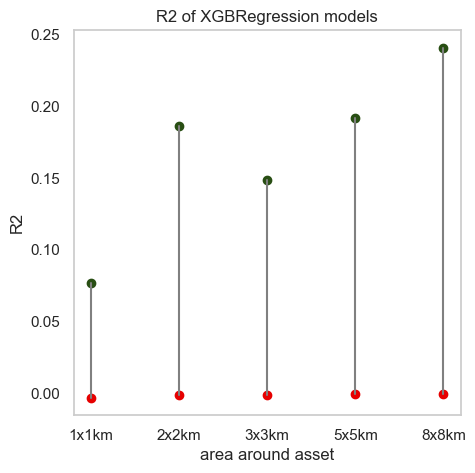

In [406]:
# plot
fig, ax = plt.subplots(figsize=(5, 5))

# connecting lines
a = [[x, y] for x, y in zip(list(range(6)), baseline_r2.values())]
b = [[x, y] for x, y in zip(list(range(6)), xgb_cv_r2.values())]

ab_pairs = np.c_[a, b]
ab_args = ab_pairs.reshape(-1, 2, 2).swapaxes(1, 2).reshape(-1, 2)

# blobs
plt.scatter(metrics.index, metrics.xgb_cv_r2, color = forest)
plt.scatter(metrics.index, metrics.baseline_r2, color = '#e60000')

# sauce
plt.plot(*ab_args, color = 'grey')
plt.ylabel('R2')
plt.xlabel('area around asset')
plt.xticks(metrics.index, ['1x1km', '2x2km', '3x3km', '5x5km', '8x8km'])
plt.title('R2 of XGBRegression models')
plt.grid()

plt.show()
plt.clf


fig.savefig('graphs/model_r2.png', bbox_inches='tight')

# ab_args_copy


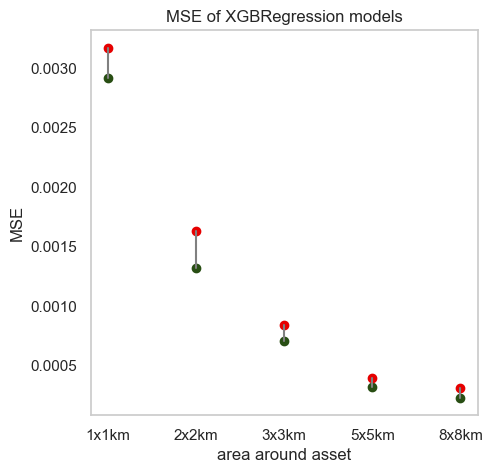

<Figure size 640x480 with 0 Axes>

In [410]:
# plot
fig, ax = plt.subplots(figsize=(5, 5))

# connecting lines
a = [[x, y] for x, y in zip(list(range(6)), baseline_mse.values())]
b = [[x, y] for x, y in zip(list(range(6)), xgb_cv_mse.values())]

ab_pairs = np.c_[a, b]
ab_args = ab_pairs.reshape(-1, 2, 2).swapaxes(1, 2).reshape(-1, 2)

# blobs
plt.scatter(metrics.index, metrics.xgb_cv_mse, color = forest)
plt.scatter(metrics.index, metrics.baseline_mse, color = '#e60000')

# sauce
plt.plot(*ab_args, color = 'grey')
plt.ylabel('MSE')
plt.xlabel('area around asset')
plt.xticks(metrics.index, ['1x1km', '2x2km', '3x3km', '5x5km', '8x8km'])
plt.title('MSE of XGBRegression models')
plt.grid()

plt.show()
plt.clf()

fig.savefig('graphs/model_mse.png', bbox_inches='tight')
